### Solving MNIST

Problem statement: Predict digit value given handwriting picture (28 x 28 pixel)
Type: Multiclass Classification (0-9 digit)
Performance metric: Accuracy; Since number of samples each label is quite the same.

The problem might be solved by these learning algorithms:
1. Multiclass Classifier
2. Ensemble Binary Classifier
3. Multilayer Perceptron
4. Convolutional Neural Network

What I did in this notebook:
1. Data pre-processing:
    a. Flatten the data (for Multiclass Classifier, Ensemble Binary Classifier, Multilayer Perceptron).
    b. Normalize the data so it could be faster to converge.
2. Modelling:
    a. Compare performance metric on cross-validation for each learning algorithm.

In [1]:
# Library

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 

import warnings
warnings.filterwarnings('ignore')

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [3]:
# Read file
df_train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
df_test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

X_train = df_train.iloc[:,1:]
y_train = df_train.iloc[:,0]

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    stratify = y_train,
                                                    test_size=0.2, random_state = 41)

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((33600, 784), (33600,), (8400, 784), (8400,))

#### Data Pre-Processing
In this section, I want to see samples of training data; and prepare the dataset so it could be fed into learning algorithm.

In [4]:
# Proportion of samples per digit in training dataset
# I need to make sure whether the dataset is balance or imbalance

unique, counts = np.unique(y_train, return_counts=True)
proportions = counts/counts.sum()
dict(zip(unique, proportions))

# The samples are slightly well distributed. The proportion of each label between 9-10%.

{0: 0.09839285714285714,
 1: 0.11151785714285714,
 2: 0.09946428571428571,
 3: 0.10360119047619047,
 4: 0.09696428571428571,
 5: 0.09035714285714286,
 6: 0.09848214285714285,
 7: 0.10479166666666667,
 8: 0.09672619047619048,
 9: 0.09970238095238096}

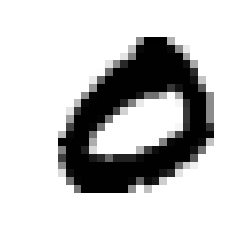

In [5]:
# See samples of the image
def series_to_array(series):
    data = np.array(series)
    return data

# Plot Digit
def plot_digit(series):
    data = series_to_array(series)
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

plot_digit(X_train.iloc[10,:])

In [6]:
# Normalize the data
# To get faster time to converge, I need to scale the feature value to the value between 0-1.
# Currently the value representation is between 0-255. So we need to divide it with 255.

X_train_flat = X_train/255
X_val_flat = X_val/255

X_train_flat.shape, X_val_flat.shape

((33600, 784), (8400, 784))

#### Modelling
In this section, I will do following tasks:
1. Prepare cross-validation function
2. Define several models
3. Compare performance metric of each models

In [7]:
# Stratified k-fold being used in order to get stratified split
skfolds = StratifiedKFold(n_splits=3)

# Calculate Accuracy using cross-validation
def calculate_cv_accuracy(model, X, y):
    acc = cross_val_score(model, X, y, cv=skfolds, scoring = "accuracy")
    return acc
    
def evaluate_models(models, X_train, y_train, X_test, y_test):
    results = []
    for name, model in models:
        cv_score = calculate_cv_accuracy(model, X_train, y_train)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred)
        results.append((name, model, cv_score.mean(), cv_score.std(), test_acc))
        msg = "{}: Accuracy on CV {} ({}); Test {}".format(name, cv_score.mean(), cv_score.std(), test_acc)
        print(msg)
    
    return results

#### Multiclass Classifier
In this section, I use Logistic Regression and Random Forest to build multiclass classifier. These two learning algorithms have different approach to solve the problem and I want to see the result out of two different algorithm.

In [8]:
# Define model
logistic_multi = LogisticRegression(multi_class='multinomial') # solver sage & scaled feature are used to get faster converge time
rf_multi = RandomForestClassifier(n_estimators = 50, random_state=41)

# List of models
models = []
models.append(("Logistic Multiclass", logistic_multi))
models.append(("Random Forest Multiclass", rf_multi))

In [9]:
# Evaluate models
# The evaluation done in cross-validation and test dataset
# So I could make sure the model is not overfitting the training data
multiclass_result = evaluate_models(models, X_train_flat, y_train, X_val_flat, y_val)

Logistic Multiclass: Accuracy on CV 0.9127976190476191 (0.0018959057510277476); Test 0.9166666666666666
Random Forest Multiclass: Accuracy on CV 0.9561309523809524 (0.0005373651811091979); Test 0.9603571428571429


#### Ensemble Binary Classifiers
Instead of creating one model to classify 10 labels, I want to create 10 models for each labels and ensemble them. The ensemble learning usually have better performance if it is constructed with different models.

In [10]:
# Before creating the ensemble model,
# We need to adjust the target for each binary classifiers first

# Let's create target for binary classification
y_train_0 = (y_train == 0)
y_train_1 = (y_train == 1)
y_train_2 = (y_train == 2)
y_train_3 = (y_train == 3)
y_train_4 = (y_train == 4)
y_train_5 = (y_train == 5)
y_train_6 = (y_train == 6)
y_train_7 = (y_train == 7)
y_train_8 = (y_train == 8)
y_train_9 = (y_train == 9)
# Now we have separated target for each digit

# Lets define Binary Classifier for each digit
# I will use two type binary classifier for each digit i.e. Logistic Regression and Random Forest
rf_0 = RandomForestClassifier(n_estimators = 2, random_state=41)
rf_1 = RandomForestClassifier(n_estimators = 2, random_state=41)
rf_2 = RandomForestClassifier(n_estimators = 2, random_state=41)
rf_3 = RandomForestClassifier(n_estimators = 2, random_state=41)
rf_4 = RandomForestClassifier(n_estimators = 2, random_state=41)
rf_5 = RandomForestClassifier(n_estimators = 2, random_state=41)
rf_6 = RandomForestClassifier(n_estimators = 2, random_state=41)
rf_7 = RandomForestClassifier(n_estimators = 2, random_state=41)
rf_8 = RandomForestClassifier(n_estimators = 2, random_state=41)
rf_9 = RandomForestClassifier(n_estimators = 2, random_state=41)

logit_0 = LogisticRegression(l1_ratio= 0.5)
logit_1 = LogisticRegression(l1_ratio= 0.5)
logit_2 = LogisticRegression(l1_ratio= 0.5)
logit_3 = LogisticRegression(l1_ratio= 0.5)
logit_4 = LogisticRegression(l1_ratio= 0.5)
logit_5 = LogisticRegression(l1_ratio= 0.5)
logit_6 = LogisticRegression(l1_ratio= 0.5)
logit_7 = LogisticRegression(l1_ratio= 0.5)
logit_8 = LogisticRegression(l1_ratio= 0.5)
logit_9 = LogisticRegression(l1_ratio= 0.5)

In [11]:
# Evaluate each of binary classifiers
binary_models_rf = []
binary_models_rf.append(("Random Forest digit 0", rf_0))
binary_models_rf.append(("Random Forest digit 1", rf_1))
binary_models_rf.append(("Random Forest digit 2", rf_2))
binary_models_rf.append(("Random Forest digit 3", rf_3))
binary_models_rf.append(("Random Forest digit 4", rf_4))
binary_models_rf.append(("Random Forest digit 5", rf_5))
binary_models_rf.append(("Random Forest digit 6", rf_6))
binary_models_rf.append(("Random Forest digit 7", rf_7))
binary_models_rf.append(("Random Forest digit 8", rf_8))
binary_models_rf.append(("Random Forest digit 9", rf_9))

binary_models = []
binary_models.append(("Logistic Regression digit 0", logit_0))
binary_models.append(("Logistic Regression digit 1", logit_1))
binary_models.append(("Logistic Regression digit 2", logit_2))
binary_models.append(("Logistic Regression digit 3", logit_3))
binary_models.append(("Logistic Regression digit 4", logit_4))
binary_models.append(("Logistic Regression digit 5", logit_5))
binary_models.append(("Logistic Regression digit 6", logit_6))
binary_models.append(("Logistic Regression digit 7", logit_7))
binary_models.append(("Logistic Regression digit 8", logit_8))
binary_models.append(("Logistic Regression digit 9", logit_9))

dict_y_train = {'y_train_0': y_train_0,
               'y_train_1': y_train_1,
               'y_train_2': y_train_2,
               'y_train_3': y_train_3,
               'y_train_4': y_train_4,
               'y_train_5': y_train_5,
               'y_train_6': y_train_6,
               'y_train_7': y_train_7,
               'y_train_8': y_train_8,
               'y_train_9': y_train_9
               }
i = 0
for name, model in binary_models:
    y = ("y_train_" + str(i))
    cv_score = calculate_cv_accuracy(model, X_train_flat, dict_y_train[y])
    msg = "{}: Accuracy on CV {} ({});".format(name, cv_score.mean(), cv_score.std())
    i += 1
    print(msg)

i = 0
for name, model in binary_models_rf:
    y = ("y_train_" + str(i))
    cv_score = calculate_cv_accuracy(model, X_train_flat, dict_y_train[y])
    msg = "{}: Accuracy on CV {} ({});".format(name, cv_score.mean(), cv_score.std())
    i += 1
    print(msg)    
    
# We now have different binary classifiers for each label with different performance
# The accuracy of each binary classifiers ranging from  95% - 99%
# I am afraid that each classifiers is overfitting the training dataset

Logistic Regression digit 0: Accuracy on CV 0.9909226190476191 (0.0008636082219373046);
Logistic Regression digit 1: Accuracy on CV 0.991904761904762 (0.0004454354031873941);
Logistic Regression digit 2: Accuracy on CV 0.9774999999999999 (0.0005693787639794287);
Logistic Regression digit 3: Accuracy on CV 0.972202380952381 (0.0014161163396869245);
Logistic Regression digit 4: Accuracy on CV 0.9822321428571428 (0.0013501543121683269);
Logistic Regression digit 5: Accuracy on CV 0.9724404761904762 (0.0009951341367440683);
Logistic Regression digit 6: Accuracy on CV 0.9856250000000001 (0.0015988542879241821);
Logistic Regression digit 7: Accuracy on CV 0.9834226190476191 (0.0012570661953537248);
Logistic Regression digit 8: Accuracy on CV 0.9593154761904762 (0.0014476650603589703);
Logistic Regression digit 9: Accuracy on CV 0.9641071428571428 (0.0006479625314606278);
Random Forest digit 0: Accuracy on CV 0.9792261904761904 (0.002757115613813932);
Random Forest digit 1: Accuracy on CV 0.9

In [12]:
# Fit each of binary classifiers
rf_0.fit(X_train_flat, y_train_0)
rf_1.fit(X_train_flat, y_train_1)
rf_2.fit(X_train_flat, y_train_2)
rf_3.fit(X_train_flat, y_train_3)
rf_4.fit(X_train_flat, y_train_4)
rf_5.fit(X_train_flat, y_train_5)
rf_6.fit(X_train_flat, y_train_6)
rf_7.fit(X_train_flat, y_train_7)
rf_8.fit(X_train_flat, y_train_8)
rf_9.fit(X_train_flat, y_train_9)

logit_0.fit(X_train_flat, y_train_0)
logit_1.fit(X_train_flat, y_train_1)
logit_2.fit(X_train_flat, y_train_2)
logit_3.fit(X_train_flat, y_train_3)
logit_4.fit(X_train_flat, y_train_4)
logit_5.fit(X_train_flat, y_train_5)
logit_6.fit(X_train_flat, y_train_6)
logit_7.fit(X_train_flat, y_train_7)
logit_8.fit(X_train_flat, y_train_8)
logit_9.fit(X_train_flat, y_train_9)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
# Prepare training data for the second layer model
# The training data is the result of prediction of each models in first layer
# I'll put probability prediciton from Random Forest and Logistic Regression

def generate_second_layer_data(X):

    X2_pred_0 = rf_0.predict_proba(X)
    X2_pred_0  = [item[1] for item in X2_pred_0]
    X2_pred_1 = rf_1.predict_proba(X)
    X2_pred_1  = [item[1] for item in X2_pred_1]
    X2_pred_2 = rf_2.predict_proba(X)
    X2_pred_2  = [item[1] for item in X2_pred_2]
    X2_pred_3 = rf_3.predict_proba(X)
    X2_pred_3  = [item[1] for item in X2_pred_3]
    X2_pred_4 = rf_4.predict_proba(X)
    X2_pred_4  = [item[1] for item in X2_pred_4]
    X2_pred_5 = rf_5.predict_proba(X)
    X2_pred_5  = [item[1] for item in X2_pred_5]
    X2_pred_6 = rf_6.predict_proba(X)
    X2_pred_6  = [item[1] for item in X2_pred_6]
    X2_pred_7 = rf_7.predict_proba(X)
    X2_pred_7  = [item[1] for item in X2_pred_7]
    X2_pred_8 = rf_8.predict_proba(X)
    X2_pred_8  = [item[1] for item in X2_pred_8]
    X2_pred_9 = rf_9.predict_proba(X)
    X2_pred_9  = [item[1] for item in X2_pred_9]

    X2_log_pred_0 = logit_0.predict_proba(X)
    X2_log_pred_0  = [item[1] for item in X2_log_pred_0]
    X2_log_pred_1 = logit_1.predict_proba(X)
    X2_log_pred_1  = [item[1] for item in X2_log_pred_1]
    X2_log_pred_2 = logit_2.predict_proba(X)
    X2_log_pred_2  = [item[1] for item in X2_log_pred_2]
    X2_log_pred_3 = logit_3.predict_proba(X)
    X2_log_pred_3  = [item[1] for item in X2_log_pred_3]
    X2_log_pred_4 = logit_4.predict_proba(X)
    X2_log_pred_4  = [item[1] for item in X2_log_pred_4]
    X2_log_pred_5 = logit_5.predict_proba(X)
    X2_log_pred_5  = [item[1] for item in X2_log_pred_5]
    X2_log_pred_6 = logit_6.predict_proba(X)
    X2_log_pred_6  = [item[1] for item in X2_log_pred_6]
    X2_log_pred_7 = logit_7.predict_proba(X)
    X2_log_pred_7  = [item[1] for item in X2_log_pred_7]
    X2_log_pred_8 = logit_8.predict_proba(X)
    X2_log_pred_8  = [item[1] for item in X2_log_pred_8]
    X2_log_pred_9 = logit_9.predict_proba(X)
    X2_log_pred_9  = [item[1] for item in X2_log_pred_9]

    # Create dataframe of all the result
    data = {'X2_zero':X2_pred_0,
            'X2_log_zero':X2_log_pred_0,
            'X2_one':X2_pred_1,
            'X2_log_one':X2_log_pred_1,
            'X2_two':X2_pred_2,
            'X2_log_two':X2_log_pred_2,
            'X2_three':X2_pred_3,
            'X2_log_three':X2_log_pred_3,
            'X2_four':X2_pred_4,
            'X2_log_four':X2_log_pred_4,
            'X2_five':X2_pred_5,
            'X2_log_five':X2_log_pred_5,
            'X2_six':X2_pred_6,
            'X2_log_six':X2_log_pred_6,
            'X2_seven':X2_pred_7,
            'X2_log_seven':X2_log_pred_7,
            'X2_eight':X2_pred_8, 
            'X2_log_eight':X2_log_pred_8, 
            'X2_nine':X2_pred_9,
            'X2_log_nine':X2_log_pred_9
           }

    return pd.DataFrame(data)

In [14]:
# See samples of prediction result
df_X2 = generate_second_layer_data(X_train_flat)
df_X2.head()

,X2_zero,X2_log_zero,X2_one,X2_log_one,X2_two,X2_log_two,X2_three,X2_log_three,X2_four,X2_log_four,X2_five,X2_log_five,X2_six,X2_log_six,X2_seven,X2_log_seven,X2_eight,X2_log_eight,X2_nine,X2_log_nine
0,0.0,3.233164e-08,0.0,5.959978e-03,0.0,0.000064,0.0,0.347978,0.0,1.679473e-03,0.0,0.004894,0.0,1.601034e-06,0.0,5.208717e-03,0.0,0.026889,1.0,1.448909e-01
1,0.0,2.138870e-07,0.0,6.723117e-07,0.0,0.000070,0.0,0.000132,0.0,3.708642e-02,0.0,0.038983,0.0,6.578087e-05,0.0,4.874257e-03,0.0,0.011756,1.0,9.662300e-01
2,0.0,5.144153e-06,0.0,5.350213e-12,1.0,0.999547,0.0,0.019313,0.0,1.036980e-06,0.0,0.000198,0.0,4.397891e-05,0.5,2.229674e-05,0.0,0.000036,0.0,3.283297e-09
3,0.0,6.489376e-08,0.5,2.850726e-03,0.0,0.000192,0.0,0.000180,0.0,2.254883e-04,1.0,0.852286,0.0,3.485930e-07,0.0,3.761544e-05,0.0,0.251917,0.0,3.631009e-06
4,1.0,9.998658e-01,0.0,1.822449e-13,0.0,0.000233,0.0,0.000168,0.0,1.566109e-09,0.0,0.002296,0.0,2.531861e-08,0.0,3.185804e-12,0.0,0.000025,0.0,3.040739e-09


In [15]:
# Define model for second layer in stacking
# I will use also random forest and training it using the predictions of several models in first layer
rf_final = RandomForestClassifier(n_estimators = 10, random_state=41)
logistic_final = LogisticRegression(multi_class='multinomial', solver='saga')

rf_final.fit(df_X2, y_train)
logistic_final.fit(df_X2, y_train)

stacking_models = []
stacking_models.append(('Random Forest 2nd layer', rf_final))
stacking_models.append(('Logistic Regression 2nd layer', logistic_final))

In [16]:
# Prediction in Stacking model
# I will use test dataset to see whether the stacking model will perform better or not
df_test_X2 = generate_second_layer_data(X_val_flat)

for name, model in stacking_models:
    y_pred = model.predict(df_test_X2)
    acc = accuracy_score(y_val, y_pred)
    msg = "{}: Accuracy on Test {};".format(name, acc)
    print(msg)
    
# It turns out that our stacking model do not outperform the multiclass classifiers earlier
# The multiclass classifier has 0.9677 accuracy on test dataset
# The ensemble binary classifier has 0.9461 accuracy on test dataset
# Having these finding, We learn that multiclass random forest classifier perform better on the MNIST dataset
# I believe that the stacking model is overfitting the training dataset,
# Supporteb by the fact that each binary classifiers have really high accuracy on training dataset, but not in the test dataset.

Random Forest 2nd layer: Accuracy on Test 0.9185714285714286;
Logistic Regression 2nd layer: Accuracy on Test 0.924047619047619;


#### Multilayer Perceptron
In this section I will approach the problem using Multilayer Perceptron (MLP) or Neural Network . The implementation will be done using keras framework.

In [17]:
# Normalize the X_train and X_test
# So it could be in range of 0-1
# It will help MLP to converge faster

X_train = X_train / 255
X_val = X_val / 255

In [18]:
# Since the keras only take input of array, I need to convert dataframe to array
arr_X_train = X_train.to_numpy()
arr_X_val = X_val.to_numpy()
arr_y_train = y_train.to_numpy()
arr_y_val = y_val.to_numpy()

In [19]:
# First I need to define the model first
# I will use 2 hidden layers in this model and 384/256 units for each layers
# I will use elu activation and set he initialization of each weight
# L1 regularization is applied to get faster convergence time in sparse dataset like MNIST

mlp_model = keras.Sequential([
#     keras.layers.Flatten(input_shape = (28,28)),
    keras.layers.Dense(384, activation= 'relu'
                       , kernel_initializer= 'he_normal'
                       , kernel_regularizer= keras.regularizers.l1(0.00001)
                      ),
    keras.layers.Dense(256, activation= 'relu'
                       , kernel_initializer= 'he_normal'
                       , kernel_regularizer= keras.regularizers.l1(0.0001)
                      ),
    keras.layers.Dense(10)
])

In [20]:
# Compile the model
mlp_model.compile(optimizer= 'adam',
                  loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics= ['accuracy']
                 )

In [21]:
# Train the model
mlp_model.fit(arr_X_train, arr_y_train, epochs=8)

Train on 33600 samples
Epoch 1/8
33600/33600 [==============================] - 4s 128us/sample - loss: 0.6792 - accuracy: 0.9238
Epoch 2/8
33600/33600 [==============================] - 3s 87us/sample - loss: 0.3544 - accuracy: 0.9651
Epoch 3/8
33600/33600 [==============================] - 3s 86us/sample - loss: 0.2574 - accuracy: 0.9732
Epoch 4/8
33600/33600 [==============================] - 3s 92us/sample - loss: 0.2097 - accuracy: 0.9782
Epoch 5/8
33600/33600 [==============================] - 3s 87us/sample - loss: 0.1782 - accuracy: 0.9824
Epoch 6/8
33600/33600 [==============================] - 3s 88us/sample - loss: 0.1525 - accuracy: 0.9858
Epoch 7/8
33600/33600 [==============================] - 3s 85us/sample - loss: 0.1339 - accuracy: 0.9883
Epoch 8/8
33600/33600 [==============================] - 3s 89us/sample - loss: 0.1225 - accuracy: 0.9886


In [22]:
# Evaluate model in test dataset
test_loss, test_accuracy = mlp_model.evaluate(arr_X_val,arr_y_val, verbose= 0)
print("MLP Accuracy on Test: {}".format(test_accuracy))

# It turns out that MLP model do outperform the multiclass classifiers earlier
# It has 0.98 accuracy on test dataset! 0.0073 better!
# The multiclass classifier has 0.9677 accuracy on test dataset
# The ensemble binary classifier has 0.9461 accuracy on test dataset

MLP Accuracy on Test: 0.9770237803459167


In [23]:
# Create prediction
# Prediction for submission
arr_X_test = df_test.to_numpy()
arr_X_test = arr_X_test / 255
arr_y_pred = mlp_model.predict(arr_X_test)

y_pred_mlp = []
for i in range(len(arr_y_pred)):
    y_pred_mlp.append(np.argmax(arr_y_pred[i]))

In [24]:
# Create file submisssion from MLP
submission_mlp = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
submission_mlp.iloc[:,1] = (y_pred_mlp)
submission_mlp.to_csv("submission_mlp.csv", index=False)

#### Convolutional Neural Network (CNN)
In this section I will approach the problem using Convolutional Neural Network (CNN). The difference with pervious MLP is instead of connecting all feature to all units in layer, it selects only particular visual receptor. The CNN often use in visual applications such as object detection and semantic segmentation.

In [25]:
arr_X_train.shape

(33600, 784)

In [26]:
# Prepare dataset for CNN

# Get data from previous model
arr_X_train = X_train.to_numpy()
arr_X_val = X_val.to_numpy()
arr_y_train = y_train.to_numpy()
arr_y_val = y_val.to_numpy()

# Get data from csv file and normalize it
arr_X_test = df_test.to_numpy()
arr_X_test = arr_X_test / 255

# input image dimensions
img_rows, img_cols = 28, 28
num_classes = 10

# Reshape the array to (28,28,1)
X_train = arr_X_train.reshape(arr_X_train.shape[0], img_rows, img_cols, 1)
X_val = arr_X_val.reshape(arr_X_val.shape[0], img_rows, img_cols, 1)
X_test = arr_X_test.reshape(arr_X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((33600, 28, 28, 1),
 (33600, 10),
 (8400, 28, 28, 1),
 (8400, 10),
 (28000, 28, 28, 1))

In [27]:
# Define CNN architecture
# The model is constructed by several layers
# I use relu activation and he initializer to get faster converge time
# The first layer is convolutional layer with 16 filter, 3x3 kernel size, 1 stride
# The second layer is the same with the first layer. They are supposed to capture feature maps from digit image.
# The third layer is pooling with maximum aggregation. It is used to reduce the size of feature maps.
# The fourth layer is convolutional layer for the result from maximum pooling.
# The next layer is dense neural network with 256 units, before feeding this layer with data I need to flatten first the data
# The last layer / output layer is dense neural network with 10 units (the same with number of class)

cnn_model = keras.models.Sequential([
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape, kernel_initializer= 'he_normal'),
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer= 'he_normal'),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer= 'he_normal'),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu', kernel_initializer= 'he_normal'),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [28]:
# Compile the model
cnn_model.compile(optimizer= 'adam',
                  loss=keras.losses.categorical_crossentropy,
                  metrics= ['accuracy']
                 )

In [29]:
# Train the model
cnn_model.fit(X_train, y_train, epochs=3)

Train on 33600 samples
Epoch 1/3
33600/33600 [==============================] - 7s 215us/sample - loss: 0.1790 - accuracy: 0.9451
Epoch 2/3
33600/33600 [==============================] - 4s 118us/sample - loss: 0.0558 - accuracy: 0.9825
Epoch 3/3
33600/33600 [==============================] - 5s 134us/sample - loss: 0.0395 - accuracy: 0.9868


In [30]:
## Evaluate model in test dataset
test_loss, test_accuracy = cnn_model.evaluate(X_val, y_val, verbose= 0)
print("CNN Accuracy on Test: {}".format(test_accuracy))

# It turns out that CNN model do outperform previos models
# It has 0.99 accuracy on test dataset!!! 0.01 better than MLP. It is huge improvement.

CNN Accuracy on Test: 0.9851190447807312


In [31]:
# Prediction for submission
arr_y_pred = cnn_model.predict(X_test)

In [32]:
# Create list of prediction
y_pred = []
for i in range(len(arr_y_pred)):
    y_pred.append(np.argmax(arr_y_pred[i]))    

In [33]:
# Create file submisssion from CNN
submission_cnn = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
submission_cnn.iloc[:,1] = (y_pred)
submission_cnn.to_csv("submission_cnn.csv", index=False)